In [205]:
import pandas as pd
from datetime import datetime
import pylab as plt
import numpy as np
import glob
import os
import sys
import matplotlib
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy.ma as ma

In [2]:
data_path = r"/home/znjs2/input_data/atom_data_02_20/processed/all_atom_ch4_data"
outfile = '/home/znjs2/output/vertical_profiles'

In [3]:
loc_data = pd.read_csv(data_path, delimiter=',', 
                        na_values = [-99999, -9999, -999, -888], 
                        parse_dates=[0], 
                        index_col=0,
                        usecols = ['UTC_Start','G_LAT','G_LONG','G_ALT','CH4_PECD'])

print(loc_data.iloc[:3])

              G_LAT     G_LONG  G_ALT  CH4_PECD
UTC_Start                                      
73265.0   -43.47749  172.54577   88.7       NaN
73266.0   -43.47688  172.54648   98.1       NaN
73267.0   -43.47627  172.54718  108.3       NaN


In [4]:
#select only rows with non nan ch4 data
meas_path = loc_data.dropna(subset=['CH4_PECD'])
print(meas_path.shape)

(7208, 4)


## Plots of flight paths

In [207]:
matplotlib.style.reload_library()
matplotlib.style.use('test_style')

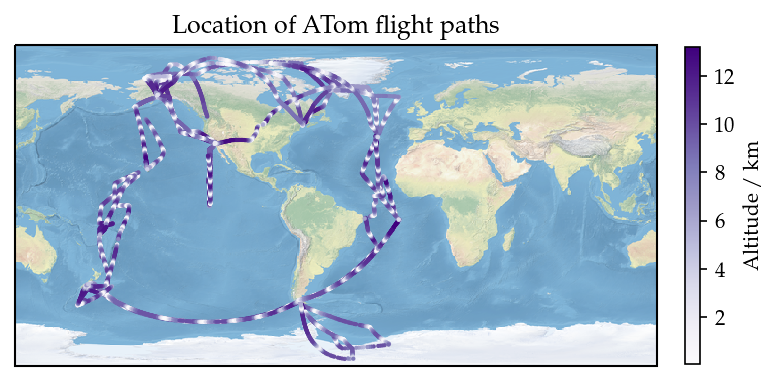

In [209]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-50))
#ax.coastlines(linewidth=0.5)
ax.stock_img()
ax.set_extent([150, 0, -90, 90])

#ax.set_xlim(0,360)
plt.scatter(meas_path.iloc[:,1]+50,meas_path.iloc[:,0], s=1, c=meas_path.iloc[:,2]/1000, cmap='Purples')

cbar = plt.colorbar(shrink = 0.7,fraction = 0.04, pad=0.04)
cbar.set_label('Altitude / km')
plt.title('Location of ATom flight paths')
plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

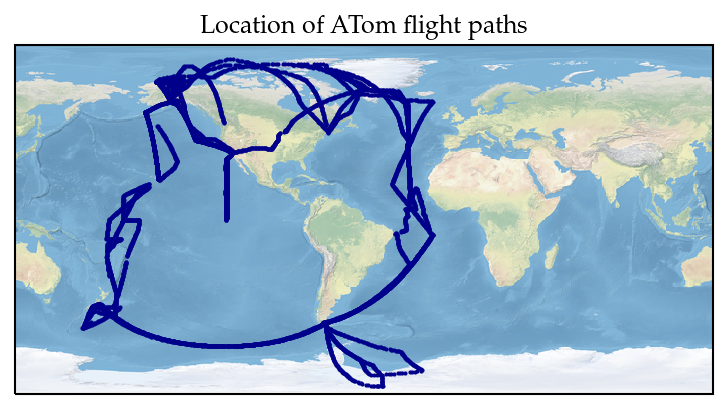

In [210]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=310.0))
#ax.coastlines()
ax.stock_img()
#ax.set_xlim(200,360)
plt.scatter(meas_path.iloc[:,1]+50,meas_path.iloc[:,0], s=1, c='darkblue')

plt.title('Location of ATom flight paths')
plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

## Bin latitudes to model grid (test)

In [7]:
lat_all = list(range(-90,91,10))
lon_all = list(range(-180,181,10))

[-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[-180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]


In [8]:
lats = np.empty(len(meas_path))

#put all ATom data into lat bins
for i in range(len(meas_path)):
    for ind1 in range(len(lat_all)):
        lat_val = meas_path.iloc[i,0]
        if lat_val >= lat_all[ind1] and lat_val <= lat_all[ind1+1]:
            #print(meas_path.iloc[i,0])
            lats[i] = lat_all[ind1]+5
            #print(lat_all[ind1]+5)

In [9]:
lons = np.empty(len(meas_path))

#put all ATom data into lon bins
for i in range(len(meas_path)):
    for ind2 in range(len(lon_all)):
        lon_val = meas_path.iloc[i,1]
        if lon_val >= lon_all[ind2] and lon_val <= lon_all[ind2+1]:
            lons[i] = lon_all[ind2]+5

## Locations of ATom measurement

Text(0.5, 1.0, 'ATom measurement range')

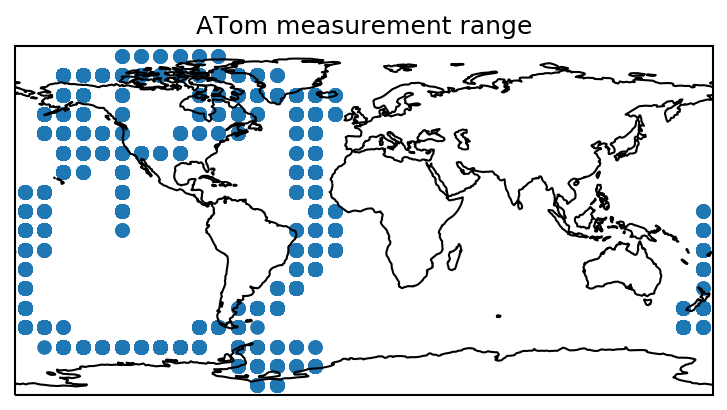

In [176]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#cmap = matplotlib.cm.get_cmap('viridis')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
ax.coastlines()
plot = ax.scatter(lons,lats)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Make masked array

In [38]:
#arrays of grid bin centres
centr_lats = np.array(list(range(-85,91,5)))
centr_lons = np.array(list(range(-175,181,5)))

In [42]:
#make correct shape array of lats and lons
globe_lats = np.transpose(np.array([centr_lats]*72))
print(globe_lats.shape)

globe_lons = np.array([centr_lons]*36)
print(globe_lons.shape)

(36, 72)
(36, 72)


In [43]:
meas_loc = pd.DataFrame({'lon':lons,'lat':lats})

In [44]:
glob_mask = np.ones((len(centr_lats),len(centr_lons))) 

for row in range(len(meas_loc)): 
    #cond = globe_lats == meas_loc.iloc[m,1]) and (globe_lons == meas_loc.iloc[m,0] 
    lat_val = meas_loc.iloc[row,1] 
    lon_val = meas_loc.iloc[row,0] 
    glob_mask1 = ma.masked_where(globe_lats == lat_val,glob_mask) 
    glob_mask2 = ma.masked_where(globe_lons == lon_val,glob_mask) 
    glob_mask3 = ma.masked_where(glob_mask1.mask * glob_mask2.mask, glob_mask) 
    glob_mask = glob_mask3

Text(0.5, 1.0, 'ATom measurement range')

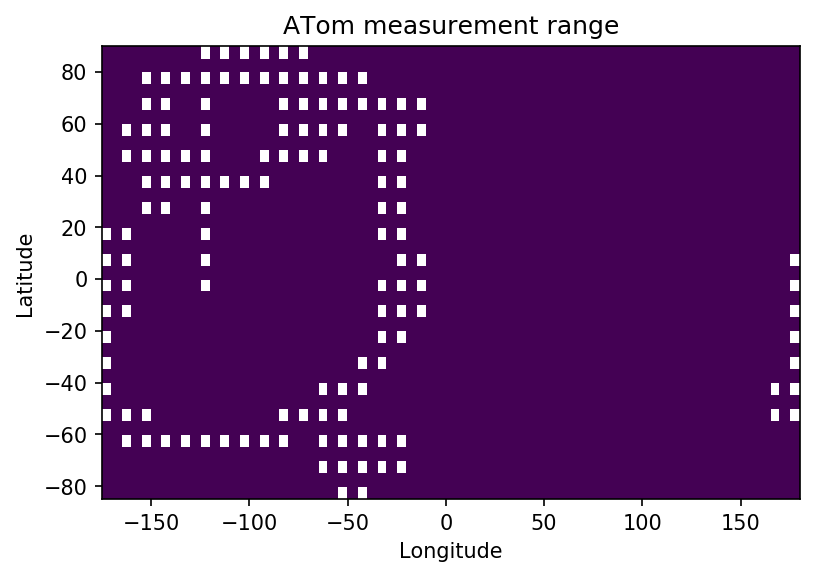

In [46]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#plt.pcolormesh(centr_lons,centr_lats,lat_mask1)
plt.pcolormesh(centr_lons,centr_lats,glob_mask)

#ax.set_xlim(150,180)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

# Actual model lat lon array

In [186]:
#define model lat and lons (N48) from xltln data
data = nc.Dataset(f'/shared/netscratch/ptg21/UM_data/xltln/xltln_ch4.nc')
mod_lat = data.variables['latitude'][:]
#mod_lon = data.variables['longitude'][:]

#define model lat and lons (N96) from bo797 data
data_n96 = nc.Dataset(f'/home/znjs2/model_data/ubo797_ch4_2016_2026.nc')
mod_lat_96 = data_n96.variables['latitude'][:]
mod_lon_96 = data_n96.variables['longitude'][:]

In [193]:
#mod_lat = list(np.arange(-90,91,2.5))
#mod_lon = np.array(np.arange(0,361,3.75))

mod_lat = list(np.arange(-90,91,1.25))#n96
mod_lon = np.array(np.arange(0,361,1.875))#n96

meas_path['lon_0'] = meas_path['G_LONG']+180

/home/znjs2/.conda/envs/basemap/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Bin latitudes to model values

In [194]:
lats_n96 = np.empty(len(meas_path))

#put all ATom data into lat bins
for i in range(len(meas_path)):
    for ind1 in range(len(mod_lat)):
        lat_val = meas_path.iloc[i,0]
        if lat_val >= mod_lat[ind1] and lat_val <= mod_lat[ind1+1]:
            #print('lat')
            #print(meas_path.iloc[i,0])
            lats_n96[i] = mod_lat[ind1]
            #print(mod_lat[ind1])
        else:
            pass

[-45. -45. -45. ...  -5.  -5.  -5.]


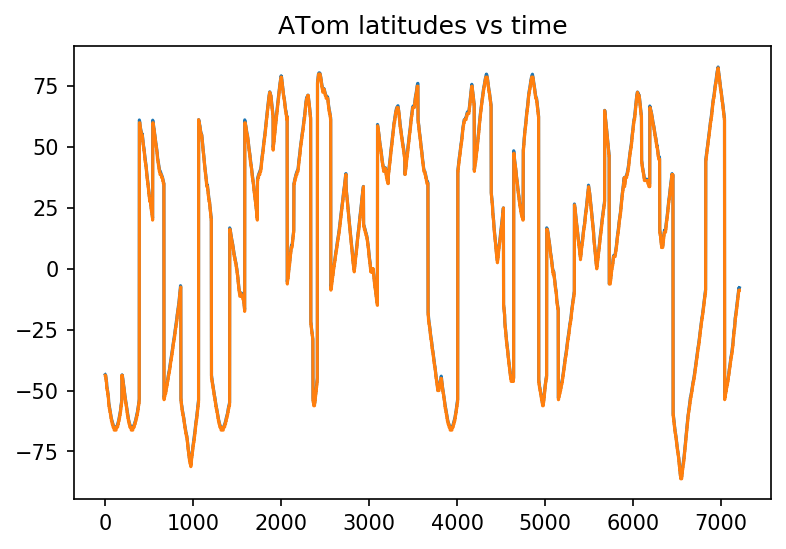

In [195]:
print(lats)
fig = plt.figure(dpi=150)
ax = plt.axes()

x_vals = list(range(len(meas_path)))

plt.plot(x_vals,meas_path.iloc[:,0])
plt.plot(lats_n96)

#ax.set_ylim(-44,-46)
#ax.set_xlim(0,100)

plt.title('ATom latitudes vs time')
#plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

## Bin longitudes to model values

In [196]:
lons_n96 = np.empty(len(meas_path))

#put all ATom data into lon bins
for i in range(len(meas_path)):
    for ind2 in range(len(mod_lon)):
        lon_val = meas_path.iloc[i,1]+180 #measured go from -180
        if lon_val >= mod_lon[ind2] and lon_val <= mod_lon[ind2]+3.75:#lon interval
            #print('lat')
            #print(lon_val)
            #print(mod_lon[ind2])
            lons_n96[i] = mod_lon[ind2]
        else:
            pass

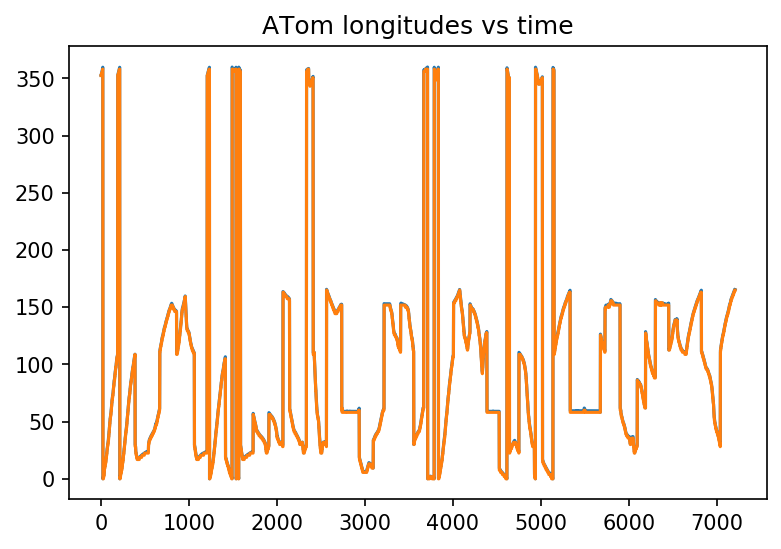

In [197]:
fig = plt.figure(dpi=150)
ax = plt.axes()

x_vals = list(range(len(meas_path)))

plt.plot(x_vals,meas_path.iloc[:,1]+180)
plt.plot(lons_n96)

#ax.set_ylim(-44,-46)
#ax.set_xlim(0,100)

plt.title('ATom longitudes vs time')
#plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

Text(0.5, 1.0, 'ATom measurement range')

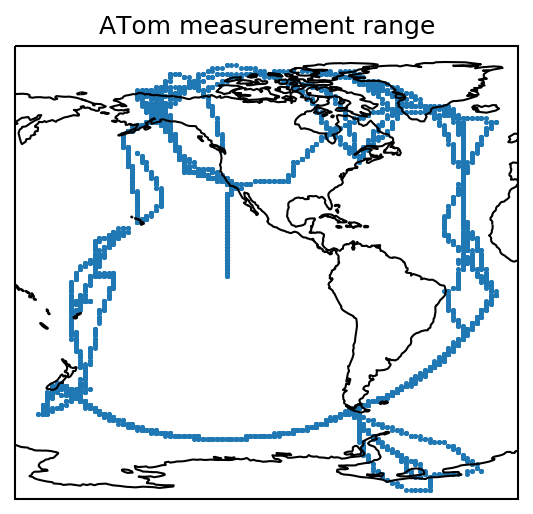

In [198]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#cmap = matplotlib.cm.get_cmap('viridis')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.coastlines()
plot = ax.scatter(lons_n96,lats_n96,s=2)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Make masked array

In [199]:
#make correct shape array of lats and lons
globe_lats_mod = np.transpose(np.array([mod_lat]*len(mod_lon)))
print(globe_lats_mod.shape)

globe_lons_mod = np.array([mod_lon]*len(mod_lat))
print(globe_lons_mod.shape)

(145, 193)
(145, 193)


In [200]:
meas_loc_n96 = pd.DataFrame({'lon':lons_n96,'lat':lats_n96})

In [201]:
glob_mask_n96 = np.ones((len(mod_lat),len(mod_lon)))

for row in range(len(meas_loc_n96)): 
    #cond = globe_lats == meas_loc.iloc[m,1]) and (globe_lons == meas_loc.iloc[m,0] 
    lat_val = meas_loc_n96.iloc[row,1] 
    lon_val = meas_loc_n96.iloc[row,0] 
    glob_mask1 = ma.masked_where(globe_lats_mod == lat_val,glob_mask_n96) 
    glob_mask2 = ma.masked_where(globe_lons_mod == lon_val,glob_mask_n96) 
    glob_mask3 = ma.masked_where(glob_mask1.mask * glob_mask2.mask, glob_mask_n96) 
    glob_mask_n96 = glob_mask3

In [202]:
inv_mask = ma.masked_where(np.invert(glob_mask_n96.mask),np.ones((len(mod_lat),len(mod_lon))))

In [203]:
np.save(f'{outfile}/ATom_lat_lon_mask_n96.npy',inv_mask.mask)

Text(0.5, 1.0, 'ATom measurement range')

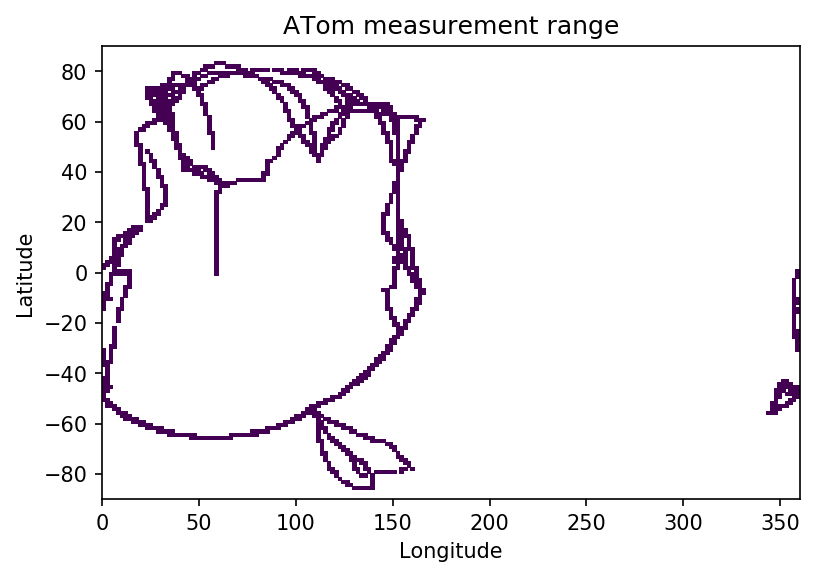

In [204]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#plt.pcolormesh(centr_lons,centr_lats,lat_mask1)
plt.pcolormesh(mod_lon,mod_lat,inv_mask)
#ax.set_xlim(150,180)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')